In [24]:
import os
import sys
import glob

sys.path.append(os.getcwd())

import torch
from lossless.component.coolchic import CoolChicEncoderParameter
from lossless.component.frame import load_frame_encoder
from lossless.component.types import NAME_COOLCHIC_ENC
from lossless.component.image import (
    FrameEncoderManager,
    encode_one_frame,
)
from enc.utils.codingstructure import CodingStructure, Frame
from typing import Any, Dict, List
from lossless.component.coolchic import CoolChicEncoder
from torchac import torchac
import numpy as np

DATASET_PATH = f"{os.getcwd()}/../datasets/kodak"
IMAGE_PATHS = sorted(
    glob.glob(f"{DATASET_PATH}/*.png"),
    key=lambda x: int(os.path.basename(x).split(".")[0][len("kodim") :]),
)
TEST_WORKDIR = f"{os.getcwd()}/test-workdir/"
PATH_COOL_CHIC_CFG = f"{os.getcwd()}/../cfg/"
print(IMAGE_PATHS)

args = {
    # not in config files
    "input": IMAGE_PATHS[0],
    "output": TEST_WORKDIR + "output",
    "workdir": TEST_WORKDIR,
    "lmbda": 1e-3,
    "job_duration_min": -1,
    "print_detailed_archi": False,
    "print_detailed_struct": False,
    # config file paths
    # encoder side
    "start_lr": 1e-2,
    "n_itr": 1,
    "n_itr_pretrain_motion": 1,
    "n_train_loops": 1,
    "preset": "debug",
    # decoder side
    "layers_synthesis_residue": "16-1-linear-relu,X-1-linear-none,X-3-residual-relu,X-3-residual-none",
    "arm_residue": "8,2",
    "n_ft_per_res_residue": "1,1,1,1,1,1,1",
    "ups_k_size_residue": 8,
    "ups_preconcat_k_size_residue": 7,
}

print(args)
print("----------")
# os.chdir(args["workdir"])

start_print = (
    "\n\n"
    "*----------------------------------------------------------------------------------------------------------*\n"
    "|                                                                                                          |\n"
    "|                                                                                                          |\n"
    "|       ,gggg,                                                                                             |\n"
    '|     ,88"""Y8b,                           ,dPYb,                             ,dPYb,                       |\n'
    "|    d8\"     `Y8                           IP'`Yb                             IP'`Yb                       |\n"
    "|   d8'   8b  d8                           I8  8I                             I8  8I      gg               |\n"
    "|  ,8I    \"Y88P'                           I8  8'                             I8  8'      \"\"               |\n"
    "|  I8'             ,ggggg,      ,ggggg,    I8 dP      aaaaaaaa        ,gggg,  I8 dPgg,    gg     ,gggg,    |\n"
    '|  d8             dP"  "Y8ggg  dP"  "Y8ggg I8dP       """"""""       dP"  "Yb I8dP" "8I   88    dP"  "Yb   |\n'
    "|  Y8,           i8'    ,8I   i8'    ,8I   I8P                      i8'       I8P    I8   88   i8'         |\n"
    "|  `Yba,,_____, ,d8,   ,d8'  ,d8,   ,d8'  ,d8b,_                   ,d8,_    _,d8     I8,_,88,_,d8,_    _   |\n"
    '|    `"Y8888888 P"Y8888P"    P"Y8888P"    8P\'"Y88                  P""Y8888PP88P     `Y88P""Y8P""Y8888PP   |\n'
    "|                                                                                                          |\n"
    "|                                                                                                          |\n"
    "| version 4.1.0, July 2025                                                              © 2023-2025 Orange |\n"
    "*----------------------------------------------------------------------------------------------------------*\n"
)
print(start_print)

['/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim02.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim03.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim04.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim05.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim06.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim07.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim08.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim09.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim10.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim11.png', '/home/ja

In [2]:
# UTIL CODE

def pretty_str_dict(d: dict[str, Any]) -> str:
    if not d:
        return ""
    
    # Find length of the longest key
    max_key_len = max(len(k) for k in d.keys())
    
    lines = []
    for key, value in d.items():
        # Pad key so values align, ensure at least one space after colon
        lines.append(f"{key}:{' ' * (max_key_len - len(key) + 1)}{value}")
    
    return "\n".join(lines)

In [3]:
# COOL CHICK PARAMETER PARSER CODE
def parse_synthesis_layers(layers_synthesis: str) -> List[str]:
    """The layers of the synthesis are presented in as a coma-separated string.
    This simply splits up the different substrings and return them.

    Args:
        layers_synthesis (str): Command line argument for the synthesis.

    Returns:
        List[str]: List of string where the i-th element described the i-th
            synthesis layer
    """
    parsed_layer_synth = [x for x in layers_synthesis.split(",") if x != ""]

    assert parsed_layer_synth, (
        "Synthesis should have at least one layer, found nothing. \n"
        f"--layers_synthesis={layers_synthesis} does not work!\n"
        "Try something like 32-1-linear-relu,X-1-linear-none,"
        "X-3-residual-relu,X-3-residual-none"
    )

    return parsed_layer_synth


def parse_n_ft_per_res(n_ft_per_res: str) -> list[int]:
    """The number of feature per resolution is a coma-separated string.
    This simply splits up the different substrings and return them.

    Args:
        n_ft_per_res (str): Something like "1,1,1,1,1,1,1" for 7 latent grids
        with different resolution and 1 feature each.

    Returns:
        List[int]: The i-th element is the number of features for the i-th
        latent, i.e. the latent of a resolution (H / 2^i, W / 2^i).
    """

    n_ft_per_res_int = [int(x) for x in n_ft_per_res.split(",") if x != ""]
    # assert set(n_ft_per_res) == {
    #     1
    # }, f"--n_ft_per_res should only contains 1. Found {n_ft_per_res}"
    return n_ft_per_res_int


def parse_arm_archi(arm: str) -> Dict[str, int]:
    """The arm is described as <dim_arm>,<n_hidden_layers_arm>.
    Split up this string to return the value as a dict.

    Args:
        arm (str): Command line argument for the ARM.

    Returns:
        Dict[str, int]: The ARM architecture
    """
    assert len(arm.split(",")) == 2, (
        f"--arm format should be X,Y." f" Found {arm}"
    )

    dim_arm, n_hidden_layers_arm = [int(x) for x in arm.split(",")]
    arm_param = {"dim_arm": dim_arm, "n_hidden_layers_arm": n_hidden_layers_arm}
    return arm_param


def get_coolchic_param_from_args(
    args: dict,
    coolchic_enc_name: str,
) -> Dict[str, Any]:
    layers_synthesis = parse_synthesis_layers(
        args[f"layers_synthesis_{coolchic_enc_name}"]
    )
    n_ft_per_res = parse_n_ft_per_res(args[f"n_ft_per_res_{coolchic_enc_name}"])

    coolchic_param = {
        "layers_synthesis": layers_synthesis,
        "n_ft_per_res": n_ft_per_res,
        "ups_k_size": args[f"ups_k_size_{coolchic_enc_name}"],
        "ups_preconcat_k_size": args[
            f"ups_preconcat_k_size_{coolchic_enc_name}"
        ],
    }

    # Add ARM parameters
    coolchic_param.update(parse_arm_archi(args[f"arm_{coolchic_enc_name}"]))

    return coolchic_param

def change_n_out_synth(layers_synth: List[str], n_out: int) -> List[str]:
        """Change the number of output features in the list of strings
        describing the synthesis architecture. It replaces "X" with n_out. E.g.

        From [8-1-linear-relu,X-1-linear-none,X-3-residual-none]
        To   [8-1-linear-relu,2-1-linear-none,2-3-residual-none]

        If n_out = 2

        Args:
            layers_synth (List[str]): List of strings describing the different
                synthesis layers
            n_out (int): Number of desired output.

        Returns:
            List[str]: List of strings with the proper number of output features.
        """
        return [lay.replace("X", str(n_out)) for lay in layers_synth]

In [4]:
# remove the content of the workdir if it exists
if os.path.exists(args["workdir"]):
    print(f"Removing {args['workdir']}...")
    for file in os.listdir(args["workdir"]):
        file_path = os.path.join(args["workdir"], file)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")


Removing /home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/test-workdir/...


In [33]:

encoder_param = CoolChicEncoderParameter(
    **get_coolchic_param_from_args(args, "residue")
)
encoder_param.set_image_size((512, 768))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 6
)

coolchic = CoolChicEncoder(param=encoder_param)
coolchic.eval()

for i, grid in enumerate(coolchic.latent_grids):
    # Instead of default initialization, use larger values
    grid.data.normal_(0.2, 0.5)  # Mean=0, std=0.5 instead of very small values
    print(f"   Reinitialized Grid {i}: mean={grid.data.mean():.4f}, std={grid.data.std():.4f}")
    
# print(coolchic.pretty_string(True))
with torch.no_grad():
    # Forward pass with no quantization noise
    # This is a random prior, i.e. the output is not conditioned on any input
    # image.
    random_prior = coolchic.forward(
            quantizer_noise_type="none",
            quantizer_type="hardround",
            AC_MAX_VAL=-1,
            flag_additional_outputs=False,
        )
print(f"Random prior: {random_prior.keys()}")

   Reinitialized Grid 0: mean=0.2006, std=0.5004
   Reinitialized Grid 1: mean=0.1993, std=0.5012
   Reinitialized Grid 2: mean=0.1963, std=0.4982
   Reinitialized Grid 3: mean=0.1893, std=0.4951
   Reinitialized Grid 4: mean=0.1970, std=0.4881
   Reinitialized Grid 5: mean=0.2042, std=0.5080
   Reinitialized Grid 6: mean=0.2084, std=0.5109
Random prior: dict_keys(['raw_out', 'rate', 'additional_data'])


torch.Size([1, 6, 512, 768])
torch.Size([524256])
tensor(0.) tensor(0.0019)


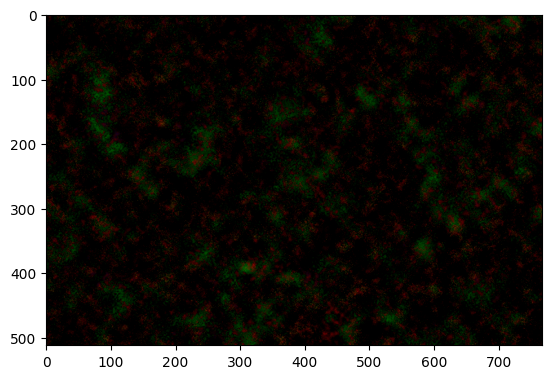

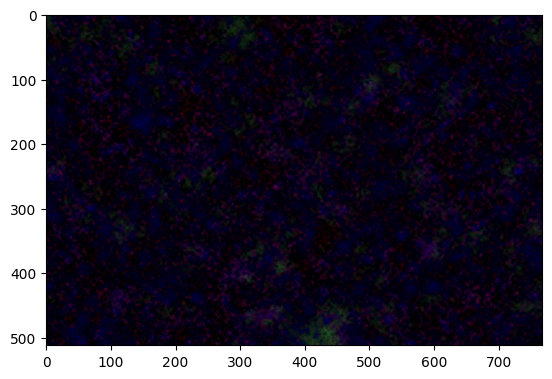

In [34]:
import matplotlib.pyplot as plt

print(random_prior["raw_out"].size())
print(random_prior["rate"].size())
# print(random_prior["additional_data"])
print(torch.min(random_prior["raw_out"]), torch.max(random_prior["raw_out"]))

plt.imshow(random_prior["raw_out"].cpu().numpy()[0, :3].transpose(1, 2, 0) * 255, cmap="gray")
plt.show()
plt.imshow(random_prior["raw_out"].cpu().numpy()[0, 3:6].transpose(1, 2, 0) * 255, cmap="gray")
plt.show()

In [52]:
rans_freq_precision:int = 16

def modify_regular_prob(probs:torch.Tensor)->torch.Tensor:
    '''
        function to modify the frequencies of the symbols that all possible value has at lease 1 frequency and the sum of the frequencies is 2**rans_freq_precision
    '''
    a = 2 ** (-rans_freq_precision)
    n = 256
    probs = probs*(1-n*a)+a
    return probs

def compute_logistic_cdfs(mu:torch.Tensor, scale:torch.Tensor, bitdepth:int)->torch.Tensor:
    '''
        function to calculate the cdfs of the Logistic(mu, scale) distribution
        used for encoder
    '''
    mu = mu
    scale = scale
    n,c,h,w=mu.shape
    max_v = float((1<<bitdepth)-1)
    size = 1 << bitdepth
    interval = 1. / max_v
    endpoints = torch.arange(-1.0+interval,1.0, 2*interval, device=mu.device).repeat((n,c,h,w,1)) # n c w h maxv
    mu = mu.unsqueeze(-1).repeat((1,1,1,1,size-1)) # n c w h maxv
    scale = scale.unsqueeze(-1).repeat((1,1,1,1,size-1)) # n c w h maxv
    invscale = 1. / scale
    endpoints_rescaled = (endpoints-mu)*invscale
    cdfs = torch.zeros(n,c,h,w,size+1, device=mu.device)
    cdfs[...,1:-1] = torch.sigmoid(endpoints_rescaled)
    cdfs[...,-1] = 1.0
    probs = cdfs[...,1:] - cdfs[...,:-1]
    probs = modify_regular_prob(probs)
    torch.use_deterministic_algorithms(False)
    cdfs[...,1:] = torch.cumsum(probs, dim=-1)
    torch.use_deterministic_algorithms(True)
    cdfs[...,-1] = 1.0
    cdfs_q = torch.round(cdfs * float(1<<rans_freq_precision)).to(torch.int16)
    return cdfs_q

def encode(x:torch.Tensor, mu:torch.Tensor, scale:torch.Tensor):
    x_maxv = (1 << 8) - 1
    x = torch.round(x_maxv*x).to(torch.int16).float()/x_maxv
    x_reshape = torch.round(x * ((1 << 8) - 1)).to(torch.int16).cpu()

    byte_strings = []
    for i in range(3):
        symbols = x_reshape[:,i:i+1,...]
        print(f"Channel {i}: symbols shape {symbols.shape}, min {symbols.min()}, max {symbols.max()}")
        cur_cdfs = compute_logistic_cdfs(mu[:,i:i+1,...], scale[:,i:i+1,...], 8).cpu()
        byte_strings.append(torchac.encode_int16_normalized_cdf(cur_cdfs, symbols))
    return byte_strings


def decode(byte_strings:list, mu:torch.Tensor, scale:torch.Tensor):
    assert len(byte_strings) == 3
    x_maxv = (1 << 8) - 1
    
    _, _, h, w = mu.size()
    x_rec = torch.zeros(1, 3, h, w)

    # Channel 0 (Red)
    cur_cdfs_r = compute_logistic_cdfs(mu[:,:1,...], scale[:,:1,...], 8).cpu()
    symbols_r = torchac.decode_int16_normalized_cdf(cur_cdfs_r, byte_strings[0])
    print(f"Decoded R: shape {symbols_r.shape}, min {symbols_r.min()}, max {symbols_r.max()}")
    x_r = symbols_r.reshape(1, 1, h, w).float() / x_maxv
    x_rec[:,0:1,...] = x_r  # FIX: was using 3*i (which is 0), should be 0:1

    # Channel 1 (Green)  
    cur_cdfs_g = compute_logistic_cdfs(mu[:,1:2,...], scale[:,1:2,...], 8).cpu()
    symbols_g = torchac.decode_int16_normalized_cdf(cur_cdfs_g, byte_strings[1])
    print(f"Decoded G: shape {symbols_g.shape}, min {symbols_g.min()}, max {symbols_g.max()}")
    x_g = symbols_g.reshape(1, 1, h, w).float() / x_maxv
    x_rec[:,1:2,...] = x_g  # FIX: was using 3*i+1 (which is 1), should be 1:2

    # Channel 2 (Blue)
    cur_cdfs_b = compute_logistic_cdfs(mu[:,2:3,...], scale[:,2:3,...], 8).cpu()
    symbols_b = torchac.decode_int16_normalized_cdf(cur_cdfs_b, byte_strings[2])
    print(f"Decoded B: shape {symbols_b.shape}, min {symbols_b.min()}, max {symbols_b.max()}")
    x_b = symbols_b.reshape(1, 1, h, w).float() / x_maxv
    x_rec[:,2:3,...] = x_b  # FIX: was using 3*i+2 (which is 2), should be 2:3

    return x_rec

/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png


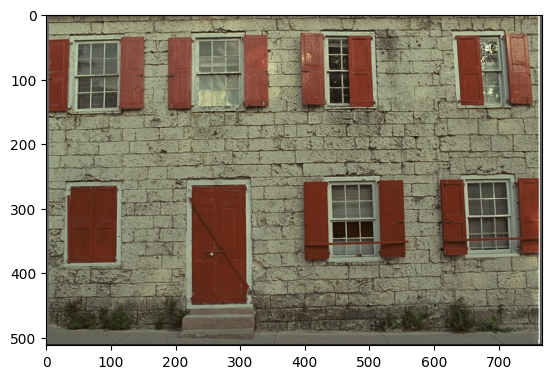

torch.Size([1, 3, 512, 768])


In [31]:
# load args["input"] image to a numpy array

import cv2
print(args["input"])
# load image in rgb way
im = cv2.imread(filename=args["input"])
assert im is not None, f"Failed to read image {args['input']}"
im = im[:, :, ::-1]  # Convert BGR to RGB

plt.imshow(im)
plt.show()

im = im.transpose(2, 0, 1)[None,]  # Change to CxHxW
im_tensor = torch.from_numpy(im.copy()).float() / 255.0  # Normalize to [0, 1]
print(im_tensor.shape)

In [49]:
mu = random_prior["raw_out"][:, :3]
scale = random_prior["raw_out"][:, 3:6]
print(mu.shape, scale.shape)


torch.Size([1, 3, 512, 768]) torch.Size([1, 3, 512, 768])


In [50]:
# assert isinstance(im, torch.Tensor), "Image should be a torch.Tensor"
# with open(args["output"] + "_encoded.bin", "wb") as f:
#     for byte_string in encode(im, mu, scale):
#         f.write(byte_string)

encoded_bytes = encode(im_tensor, mu, scale)

torch.Size([1, 1, 512, 768])
tensor(0, dtype=torch.int16) tensor(255, dtype=torch.int16)
torch.Size([1, 1, 512, 768])
tensor(0, dtype=torch.int16) tensor(255, dtype=torch.int16)
torch.Size([1, 1, 512, 768])
tensor(0, dtype=torch.int16) tensor(255, dtype=torch.int16)


In [53]:

decoded_im = decode(encoded_bytes, mu, scale)
decoded_im = decoded_im.cpu().numpy()
print(np.min(decoded_im), np.max(decoded_im))

Decoded R: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded G: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded G: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded B: shape torch.Size([1, 1, 512, 768]), min 0, max 255
0.0 1.0
Decoded B: shape torch.Size([1, 1, 512, 768]), min 0, max 255
0.0 1.0


In [ ]:
# Let's verify the fix worked by checking reconstruction
print("🔍 VERIFYING LOSSLESS RECONSTRUCTION:")
print("-" * 40)

print(f"Original image shape: {im_tensor.shape}")
print(f"Original image range: [{im_tensor.min():.6f}, {im_tensor.max():.6f}]")

print(f"\nDecoded image shape: {decoded_im.shape}")
print(f"Decoded image range: [{decoded_im.min():.6f}, {decoded_im.max():.6f}]")

# Check if reconstruction is perfect (lossless)
reconstruction_error = np.abs(im_tensor.cpu().numpy() - decoded_im).max()
print(f"\nMax reconstruction error: {reconstruction_error:.10f}")

if reconstruction_error < 1e-6:
    print("✅ SUCCESS: Perfect lossless reconstruction!")
else:
    print(f"❌ ISSUE: Reconstruction error = {reconstruction_error}")
    
    # Let's check per channel
    for i in range(3):
        channel_error = np.abs(im_tensor[0, i].cpu().numpy() - decoded_im[0, i]).max()
        print(f"   Channel {i} error: {channel_error:.10f}")

# Check some statistics
print(f"\nChannel statistics:")
for i in range(3):
    orig_mean = im_tensor[0, i].mean().item()
    decoded_mean = decoded_im[0, i].mean()
    print(f"   Channel {i}: Original mean={orig_mean:.6f}, Decoded mean={decoded_mean:.6f}")

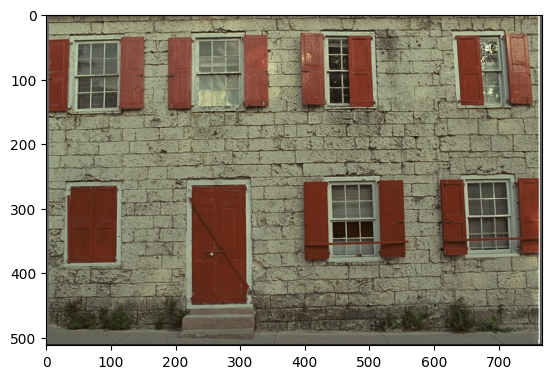

In [54]:
# decoded_im has shape torch.Size([1, 3, 512, 768])
# show it via plt

# decoded_im is a numpy array with shape (1, 3, 512, 768)
# To display as an image, we need shape (512, 768, 3)
plt.imshow(np.transpose(decoded_im[0], (1, 2, 0)))
plt.show()